## 什麼是Multimodal [entailment](https://zh.wikipedia.org/wiki/%E6%96%87%E5%AD%97%E8%98%8A%E6%B6%B5)?
- 在社群媒體平台中，我們經常會想從一段內容中，找出一些答案:
    1. 這些內容互相矛盾嗎?
    2. 這些內容隱含其他內容嗎?
- 在NLP中，這種任務稱做 textual entailment。因為內容只有文字內容。但是其實真實情況可能data不一定只有文字，還有其他類型的data，像是images, audio, video等等。
- MultiModela entailment 就是 textual entailment 的一種延伸，可以處理多種輸入的模型。

In [ ]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.4 MB 5.3 MB/s 


In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
# 資料的mapping

label_map = {
    'Contradictory': 0,
    'Implies':  1,
    'NoEntailment': 2
}

In [ ]:
# 取得資料 from google open data

image_base_path = keras.utils.get_file(
    fname="tweet_images",
    origin="https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz",
    untar=True
)
image_base_path

344285184/344273442 [==============================] - 13s 0us/step


'/root/.keras/datasets/tweet_images'

In [ ]:
# 閱讀資料集以及基本處理

df = pd.read_csv(
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv"
)
df.head()

,id_1,text_1,image_1,id_2,text_2,image_2,label
0,1375936088968200205,"150 years after its inauguration, the strategi...",http://pbs.twimg.com/media/ExeIVRBWYAAwizQ.jpg,1376653595144241155,Look how only 190 km #suezcanel carries 12% of...,http://pbs.twimg.com/media/ExrbJffWgAoBaxO.jpg,NoEntailment
1,1360981123388436489,Fall Guys is celebrating Valentine's Day with ...,http://pbs.twimg.com/media/EuMowPiXYAEylR8.jpg,1361075903606910976,Fall Guys Red Panda costume available for limi...,http://pbs.twimg.com/media/EuODUixWYAMRukK.jpg,NoEntailment
2,1336637206899945472,Impressive Batting Display From Shoaib Malik 🏏...,http://pbs.twimg.com/media/EoywcVGXMAE5FZK.jpg,1339243901799030785,"A Half century of King\n\n 🔥""Shoaib Malik"" ...",http://pbs.twimg.com/media/EpXzOwRXYAYLaCB.jpg,NoEntailment
3,1336490796279742464,How #confident are you today? https://t.co/5ay...,http://pbs.twimg.com/media/EowrS9aVEAAMhsF.jpg,1341081069248868353,How #confident are you today? https://t.co/KqZ...,http://pbs.twimg.com/media/Epx6IA-UwAA8pqN.jpg,Implies
4,1358934899256877059,The Peacocks finish out the first quarter trai...,http://pbs.twimg.com/media/EtvoCsuWQAALmyP.jpg,1361131487077228546,10 minutes gone here at home as the Peacocks l...,http://pbs.twimg.com/media/EuO1xf2XIAAOIGb.jpg,NoEntailment


### 特徵
- id_1
- text_1
- image_1
- id_2
- text_2
- image_2
- label

### 需要處理
- 文字的長度
- 影片大小
- id有甚麼特別的意義嗎?

### 任務
- 明顯是一個3分類的分類任務
- metrics: acc, cross_entropy

In [ ]:
'http://pbs.twimg.com/media/EowrS9aVEAAMhsF.jpg'.split(".")

['http://pbs', 'twimg', 'com/media/EowrS9aVEAAMhsF', 'jpg']

In [ ]:
# 將圖片位置整理出來並透過id成立新的名字
images_one_paths, images_two_paths = [], []

for i in range(len(df)):
    row = df.iloc[i, :]
    id_1 = row['id_1']
    id_2 = row['id_2']
    postfix_1 = row['image_1'].split('.')[-1]
    postfix_2 = row['image_2'].split('.')[-1]

    # 圖片位置
    image_one_path = os.path.join(image_base_path, str(id_1) + f".{postfix_1}")
    image_two_path = os.path.join(image_base_path, str(id_2) + f".{postfix_2}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)

df['image_1_path'] = images_one_paths
df['image_2_path'] = images_two_paths

# 將label轉換成數值 id
df['label_idx'] = df['label'].apply(lambda x: label_map[x])

In [ ]:
images_one_paths[:10]

['/root/.keras/datasets/tweet_images/1375936088968200205.jpg',
 '/root/.keras/datasets/tweet_images/1360981123388436489.jpg',
 '/root/.keras/datasets/tweet_images/1336637206899945472.jpg',
 '/root/.keras/datasets/tweet_images/1336490796279742464.jpg',
 '/root/.keras/datasets/tweet_images/1358934899256877059.jpg',
 '/root/.keras/datasets/tweet_images/1354383946704936961.jpg',
 '/root/.keras/datasets/tweet_images/1361247629309575175.jpg',
 '/root/.keras/datasets/tweet_images/1354642121647665153.jpg',
 '/root/.keras/datasets/tweet_images/1382000658740576258.jpg',
 '/root/.keras/datasets/tweet_images/1334036815955644419.jpg']

### 視覺化資料集

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22294 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29255 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22294 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29255 missing from current font.
  font.set_text(s, 0, flags=flags)


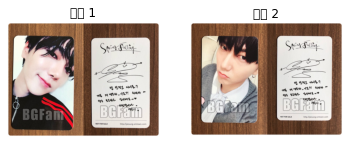

Text 1: WTS PC YESUNG [ALBUM SPRING FALLING]

💸 IDR 120.000
📍 NORTH JAKARTA
🍊AVAILABLE 

DETAILS:
✅ OFFICIAL
✅ NO DAMAGE

#Yesung #SuperJunior #SpringFalling https://t.co/ycc4ZXYOTb
Text 2: WTS PC YESUNG [ALBUM SPRING FALLING]

💸 IDR 120.000
📍 NORTH JAKARTA
🍊AVAILABLE 

DETAILS:
✅ OFFICIAL
✅ NO DAMAGE

#Yesung #SuperJunior #SpringFalling https://t.co/YcVQJBPMnw
label: NoEntailment


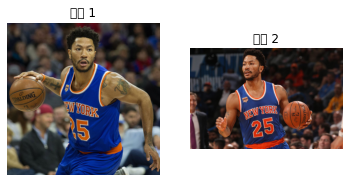

Text 1: photoshopped drose in a knicks jersey https://t.co/HhcBcMKkCX
Text 2: @TheSteinLine y’all like my derrick rose knicks photoshop? https://t.co/gyfRCELI2W
label: Implies


In [ ]:
# local可以透過這個解決中文編碼問題
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

def visualize(idx):
    """
        視覺化圖片、文字、標籤
    """
    row = df.iloc[idx, :]
    image_1 = plt.imread(row['image_1_path'])   # ndarray
    image_2 = plt.imread(row['image_2_path'])
    text_1 = row['text_1']
    text_2 = row['text_2']
    label = row['label']
    
    # (1, 2) 的idx 1視覺化
    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis('off')
    plt.title("圖片 1")
    
    # idx 2
    plt.subplot(1, 2, 2)
    plt.imshow(image_2)
    plt.axis('off')
    plt.title("圖片 2")

    plt.show()
    print(f"Text 1: {text_1}")
    print(f"Text 2: {text_2}")
    print(f"label: {label}")


random_idx = np.random.choice(len(df))
visualize(random_idx)


random_idx = np.random.choice(len(df))
visualize(random_idx)

### 分類模型需要去檢查是否有imbalanced的狀況
- 怎麼樣算是不平衡?

In [ ]:
df['label'].value_counts()

NoEntailment     1182
Implies           109
Contradictory     109
Name: label, dtype: int64

In [ ]:
label_map

{'Contradictory': 0, 'Implies': 1, 'NoEntailment': 2}

In [ ]:
# 0.9, 0.05, 0.05

train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df['label'].values, random_state=222
)

train_df, val_df = train_test_split(
    train_df, test_size=0.05, stratify=train_df['label'].values, random_state=222
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 1197
Total validation examples: 63
Total test examples: 140


### 資料 pipeline
- tensorflow hub 提供許多 BERT 家族的模型。也有許多preprocessing layer可以供挑選
- 為了要讓資料處理快速，挑一個小一定的模型
- [tf hub教學](https://www.tensorflow.org/text/tutorials/bert_glue)

In [ ]:
# 定義 tf hub paths for BERT encoder and preprocessor

bert_model_path = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

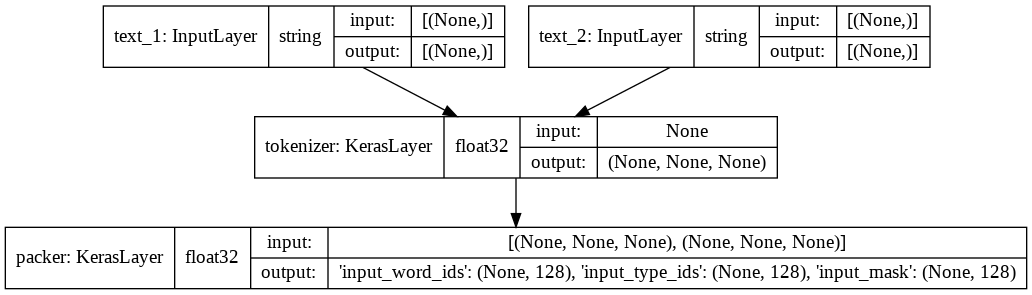

In [ ]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=f) for f in sentence_features
    ]

    # Tokensize 文字到word pieces
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(handle=bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # 可選擇要不要: 將segments trim 去fit seq_length
    truncated_segments = segments

    # 將模型輸入(也是之後模型的輸入) 打包
    packer = hub.KerasLayer(
        handle=bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer"
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)

# 得到BERT模型前處理layer
bert_preprocess_model = make_bert_preprocessing_model(['text_1', 'text_2'])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

### 實際運行看看前處理


In [ ]:
# 挑選一個樣本
idx =  np.random.choice(len(train_df))
row = train_df.iloc[idx, :]
sample_text_1, sample_text_2 = row['text_1'], row['text_2']
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

# 打包成輸入
test_text = [np.array([sample_text_1]), np.array([sample_text_2])]
text_preprocessed = bert_preprocess_model(test_text)

# print 一些 細節, 根據BERT論文, 輸入為3個id, word id, segment id, mask id
print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])

Text 1: Congratulations to #ROSÉ for her 5th music show win for ‘On The Ground' 🏆🏆🏆🏆🏆🥳

#ROSÉ5thWin #OnTheGround5thWin https://t.co/qa1Ztljimv
Text 2: Another win for our Soloist Rosé 🥳 Congratulations and you deserve it! 
🏆🏆🏆🏆🏆

#ROSÉ5thWin #OnTheGround5thWin https://t.co/Kq8uzVDHOP
Keys           :  ['input_word_ids', 'input_type_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101 23156  2000  1001  3123  2005  2014  4833  2189  2265  2663  2005
  1520  2006  1996  2598], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [ ]:
tf.squeeze(text_preprocessed['input_word_ids'])

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101, 23156,  2000,  1001,  3123,  2005,  2014,  4833,  2189,
        2265,  2663,  2005,  1520,  2006,  1996,  2598,  1005,   100,
        1001,  3123,  2629,  2705, 10105,  1001,  2006, 10760, 16365,
        2629,  2705, 10105, 16770,  1024,  1013,  1013,  1056,  1012,
        2522,  1013,  1053, 27717,  2480, 19646,  4478,  2213,  2615,
         102,  2178,  2663,  2005,  2256, 16504,  3123,   100, 23156,
        1998,  2017, 10107,  2009,   999,   100,  1001,  3123,  2629,
        2705, 10105,  1001,  2006, 10760, 16365,  2629,  2705, 10105,
       16770,  1024,  1013,  1013,  1056,  1012,  2522,  1013,  1047,
        4160,  2620, 17040, 16872, 18471,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

接著將輸入使用 tf.data.Dataset 將其包裝(常用方式)

text inputs 將會被當作資料處理pipeline的一部分，將與BERT主模型做切割，可以減少主模型運行時間，可以真的"預處理"

In [ ]:
def df_to_dataset(df):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_idx"]
    df = df[columns].copy()
    labels = df.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds

前處理 utilities

In [ ]:
resize = (128, 128)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]
    image = tf.io.read_file(image_path)     # 先讀取成二進製
    if extension == b"jpg":
        image = tf.image.decode_jpeg(contents=image, channels=3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image

def preprocess_text(text_1, text_2):
    text_1 = tf.convert_to_tensor([text_1]) # 將list of string轉換成tensor
    text_2 = tf.convert_to_tensor([text_2]) # 將list of string轉換成tensor
    output = bert_preprocess_model([text_1, text_2])
    # 將(1, 128) -> (128,)
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output

def preprocess_text_and_image(sample):
    image_1 = preprocess_image(sample["image_1_path"])
    image_2 = preprocess_image(sample["image_2_path"])
    text = preprocess_text(sample["text_1"], sample["text_2"])
    return {"image_1": image_1, "image_2": image_2, "text": text}

### 將清理的function包裝進入ds

In [ ]:
batch_size = 32
auto = tf.data.AUTOTUNE

def prepare_ds(df, training=True):
    ds = df_to_dataset(df)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

train_ds = prepare_ds(train_df)
val_ds = prepare_ds(val_df, False)
test_ds = prepare_ds(test_df, False)

In [ ]:
# 查看

for batch in train_ds.take(1):
    print(batch)

({'image_1': <tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[ 25.375    ,  29.375    ,  30.375    ],
         [ 25.375    ,  29.375    ,  30.375    ],
         [ 25.375    ,  29.375    ,  30.375    ],
         ...,
         [ 25.375    ,  29.375    ,  32.375    ],
         [ 25.375    ,  29.375    ,  30.375    ],
         [ 25.375    ,  29.375    ,  30.375    ]],

        [[ 24.375    ,  28.375    ,  29.375    ],
         [ 24.375    ,  28.375    ,  29.375    ],
         [ 24.375    ,  28.375    ,  29.375    ],
         ...,
         [ 24.375    ,  28.375    ,  31.375    ],
         [ 24.375    ,  28.375    ,  29.375    ],
         [ 24.375    ,  28.375    ,  29.375    ]],

        [[ 26.132812 ,  30.132812 ,  31.132812 ],
         [ 21.710938 ,  25.710938 ,  26.710938 ],
         [124.41406  , 128.41406  , 129.41406  ],
         ...,
         [ 25.9375   ,  29.9375   ,  30.9375   ],
         [ 22.359375 ,  26.359375 ,  27.359375 ],
         [ 24.671875 ,  28.67187

### 模型建立
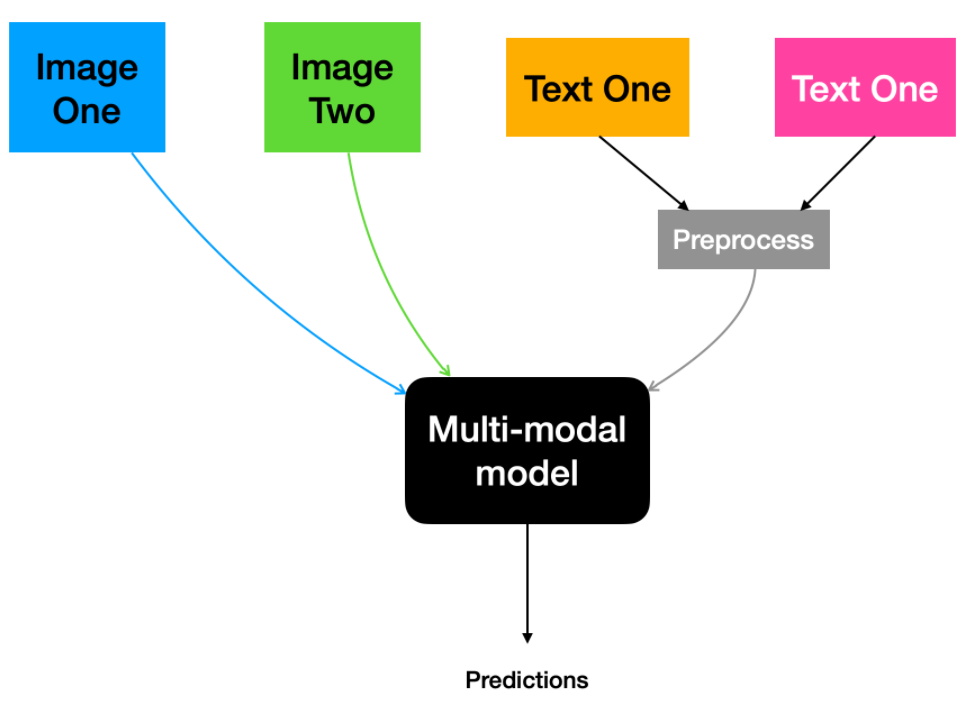

In [ ]:
# projection utilities

def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x]) # residual
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [ ]:
# vision encoder utilites: ResNet

def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # 讀取pre-trained ResNet model 
    resnet = keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",
        pooling="avg"
    )
    # trainable
    for layer in resnet.layers:
        layer.trainable = trainable

    # image inputs
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # proprocess image
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)

    # embedding
    embeddings_1 = resnet(preprocessed_1)
    embeddings_2 = resnet(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # project
    outputs = project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate)

    return keras.Model([image_1, image_2], outputs, name="vision_encoder")

In [ ]:
# text encoder

def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # 讀取pre-trained BERT
    bert = hub.KerasLayer(bert_model_path, name="bert")
    bert.trainable = trainable

    # inputs
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # embeddnig
    embeddings = bert(inputs)['pooled_output']  # CLS

    # project
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )

    return keras.Model(inputs, outputs, name="text_encoder")

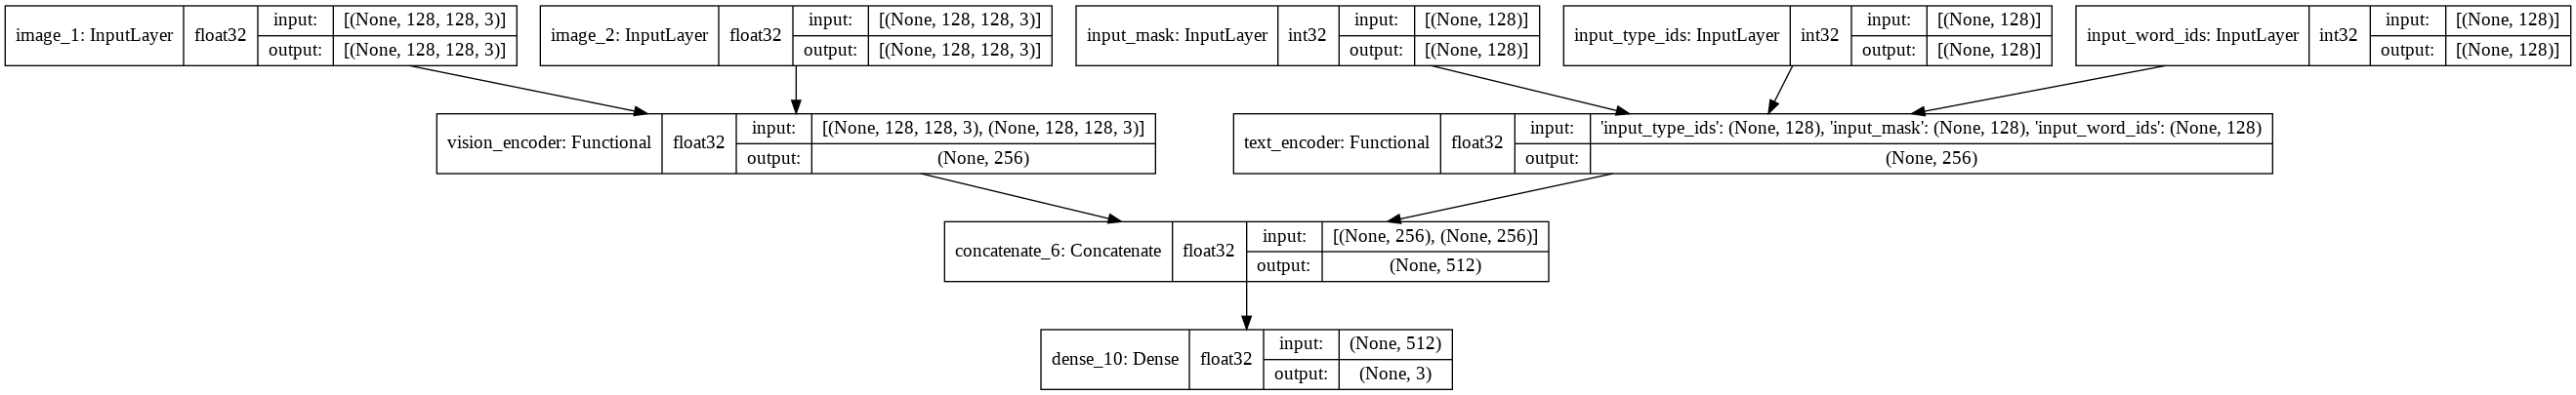

In [ ]:
# Multimodal model

def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False
):
    # inputs
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")
    bert_input_features = ['input_type_ids', 'input_mask', 'input_word_ids']
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # encoder
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # encoding
    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)

    # concatenate and classify
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation='softmax')(concatenated)
    return keras.Model([image_1, image_2, text_inputs], outputs)

multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True,show_dtype=True)

In [ ]:
# 訓練模型

multimodal_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = multimodal_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
38/38 [==============================] - 70s 791ms/step - loss: 0.9135 - acc: 0.8246 - val_loss: 0.5903 - val_acc: 0.8571
Epoch 2/10
38/38 [==============================] - 8s 223ms/step - loss: 0.4001 - acc: 0.8822 - val_loss: 0.5489 - val_acc: 0.8571
Epoch 3/10
38/38 [==============================] - 9s 226ms/step - loss: 0.3434 - acc: 0.8981 - val_loss: 0.6409 - val_acc: 0.8571
Epoch 4/10
38/38 [==============================] - 9s 227ms/step - loss: 0.2776 - acc: 0.9064 - val_loss: 0.7896 - val_acc: 0.8413
Epoch 5/10
38/38 [==============================] - 9s 228ms/step - loss: 0.2240 - acc: 0.9190 - val_loss: 1.0741 - val_acc: 0.7302
Epoch 6/10
38/38 [==============================] - 9s 226ms/step - loss: 0.3282 - acc: 0.8997 - val_loss: 0.8988 - val_acc: 0.7937
Epoch 7/10
38/38 [==============================] - 8s 225ms/step - loss: 0.2640 - acc: 0.9156 - val_loss: 1.0279 - val_acc: 0.8571
Epoch 8/10
38/38 [==============================] - 9s 227ms/step - loss: 0

In [ ]:
# 模型真實效果

_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 6s 832ms/step - loss: 1.1576 - acc: 0.8000
Accuracy on the test set: 80.0%.


In [ ]:
y_pred = multimodal_model.predict(test_ds)
print(y_pred.shape)

(140, 3)


In [ ]:
test_df['label_idx']

646     2
344     1
865     2
1210    2
1211    2
       ..
233     2
531     1
28      2
1320    2
977     2
Name: label_idx, Length: 140, dtype: int64

In [ ]:
# 因為樣本不平衡，分類效果可能是偏差的，尤其是有overfitting的情況下
from sklearn import metrics

matrix = metrics.confusion_matrix(test_df['label_idx'],y_pred.argmax(axis=1))
matrix

array([[  2,   1,   8],
       [  0,   3,   8],
       [  6,   7, 105]])

可以發現class 0, 1 預測結果都相當糟，因為不平衡關係，此兩種類別學習結果並不好。